# Demo: Instance segmentation from semantic masks

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Automatically reload imported programmes
%load_ext autoreload
%autoreload 2

# Directories (ammend as necessary)
root_dir = '/content/gdrive/MyDrive/IDSAI/PROOF/filament-segmentation'
os.chdir(root_dir)  # Move to root_dir
sys.path.insert(0, root_dir)

In [ ]:
%%script false
# Root directory containing git repo `andrw3000/filament-segmentation`
root_dir = '/Users/Holmes/Research/IDSAI/PROOF/filament-segmentation'
os.chdir(root_dir)

## File structure and imports

In [ ]:
import random
import numpy as np
from glob import glob
from skimage import io
from skimage import color
from tqdm.notebook import tqdm
from utils import get_line_instances, shade_instances, grid_display_masks
%load_ext autoreload
%autoreload 2

### Local directories

In [ ]:
# Directory containing original image and semantic mask subdirectories
data_dir = os.path.join(root_dir, 'data/tomograms2D/tf1')

# Image and semantic mask directories with identical corresponding filenames
image_dir = os.path.join(data_dir, 'png-original')
mask_dir = os.path.join(data_dir, 'png-masks/semantic')

# Experiment name
experiment = 'tf1-all'
if not os.path.exists('outputs/' + experiment):
    os.makedirs('outputs/' + experiment)

### Identify files

In [ ]:
# Uncomment as necessary to process all or a subset of filnames
file1 = 'tf1_006.png'
file2 = 'tf1_031.png'
image_names = sorted([os.path.join(image_dir, file1),
                      os.path.join(image_dir, file2)])
mask_names = sorted([os.path.join(mask_dir, file1),
                     os.path.join(mask_dir, file2)])

image_names = sorted(glob(os.path.join(image_dir, '*.png')))
mask_names = sorted(glob(os.path.join(mask_dir, '*.png')))

### Load images and masks

In [ ]:
if not image_names or not mask_names:
    raise SystemError('Image or mask directory contains no PNGs.')

images = io.imread_collection(image_names)
masks = io.imread_collection(mask_names)

# Number of Images and Mask
if not len(images) == len(masks):
    raise ValueError('Images and mask not in 1:1 correspondence')
else:
    print('Processing {} images'.format(len(images)))

print('\nSample image shape:')
print('images[0].shape =', images[0].shape)
print('masks[0].shape =', masks[0].shape)

Processing 2 images

Sample image shape:
images[0].shape = (3710, 3838)
masks[0].shape = (3710, 3838)


In [ ]:
# Ensure single channel binary masks
bmasks = []
for mask in tqdm(masks):
    if len(mask.shape) > 2:
        mask = color.rgb2gray(mask)
    bmasks.append((mask.astype(float) > 0).astype(int) * 255)
    
print('New mask shape:')
print('bmasks[0].shape =', bmasks[0].shape)


New mask shape:
bmasks[0].shape = (3710, 3838)


## Instance segmentation

### Choose hyper parameters

In [ ]:
# Minim line length to extract as proportion of longest image length
length_tol = 0.05

# Proposed pixel width of filaments
line_pixel_width = 100

# Pixel seperation between proposed lines: less -> more lines
line_sep = line_pixel_width

### Perform line extraction

In [ ]:
# Compute instances and line ends from semantic mask
instance_masks = []
for bmask in tqdm(bmasks):
    instances, line_ends = get_line_instances(
        bmask, length_tol, line_pixel_width, line_sep,
    )
    instance_masks.append((instances, line_ends))

## Outputs

### Save hyperparameter details

In [ ]:
%%capture cap_params --no-stderr
print('Hyperparameters:')
print('----------------\n')
print('length_tol = ', length_tol)
print('line_pixel_width = ', line_pixel_width)
print('line_sep = ', line_sep)

In [ ]:
# Save coordinates to text file
with open('outputs/' + experiment + '/params.txt', 'w') as f:
    f.write(str(cap_params))

### Print line ending coordinates

In [ ]:
%%capture cap_coords --no-stderr
print('Line ending pixel coords pixel (row, col)')

for file_path, (instances, line_ends) in zip(image_names, instance_masks):
    print('-----------------------------------------\n')
    print('Image filename: ', os.path.basename(file_path))
    print('Number of co-linear lines identified: ', len(instances))
    # Check line ends
    for idx, end_pairs in enumerate(line_ends):
        print('\nLine endings on line {}:'.format(idx+1))
        for ends in end_pairs:
            e1 = ends[0]
            e2 = ends[1]
            print('({e1y:d}, {e1x:d}) -> ({e2y:d}, {e2x:d})'.format(
                e1y=int(e1[0]), e1x=int(e1[1]), e2y=int(e2[0]), e2x=int(e2[1])
            ))

In [ ]:
# Print output
print(str(cap_coords))

Line ending pixel coords pixel (row, col)
-----------------------------------------

Image filename:  tf1_006.png
Number of co-linear lines identified:  27

Line endings on line 1:
(1150, 2452) -> (2570, 223)

Line endings on line 2:
(909, 1964) -> (2407, 12)

Line endings on line 3:
(851, 1852) -> (2241, 6)

Line endings on line 4:
(2339, 3802) -> (2764, 1960)
(2958, 1120) -> (3003, 922)

Line endings on line 5:
(3032, 776) -> (3464, 2810)

Line endings on line 6:
(723, 1545) -> (1546, 722)
(1945, 323) -> (2209, 59)

Line endings on line 7:
(2099, 1875) -> (3591, 2736)

Line endings on line 8:
(1963, 1828) -> (3470, 2629)

Line endings on line 9:
(1472, 2943) -> (1988, 2148)
(1989, 2146) -> (2476, 1397)

Line endings on line 10:
(756, 1531) -> (1641, 1776)
(1647, 1778) -> (2267, 1950)

Line endings on line 11:
(1532, 2498) -> (3249, 2118)

Line endings on line 12:
(1180, 2463) -> (1993, 3276)

Line endings on line 13:
(1434, 1684) -> (2676, 2148)

Line endings on line 14:
(1228, 2567)

In [ ]:
# Save coordinates to text file
with open('outputs/' + experiment + '/coords.txt', 'w') as f:
    f.write(str(cap_coords))

### Plot masked images

In [ ]:
%matplotlib inline

In [ ]:
# Load example data
name, image, mask, (instances, line_ends) = random.choice(list(zip(image_names,
                                                                   images,
                                                                   masks,
                                                                   instance_masks,
                                                                   )))

print('Graphical output for file image:', os.path.basename(name))

Graphical output for file image: tf1_006.png


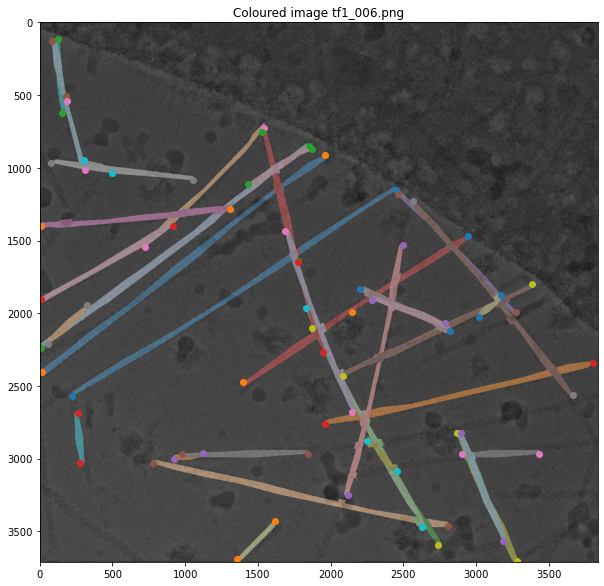

In [ ]:
# Plot grid view of instances
fig = shade_instances(os.path.basename(name), image, instances, line_ends)

### Plot masked masks

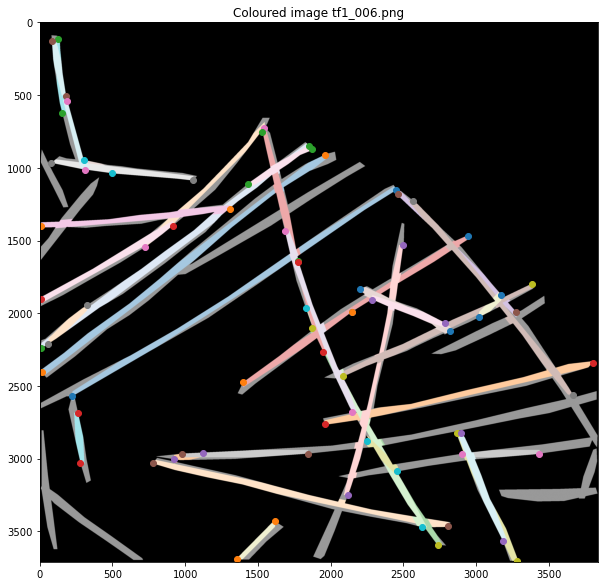

In [ ]:
# Plot grid view of instances
fig = shade_instances(os.path.basename(name), mask, instances, line_ends)

### Plot grid view of masks

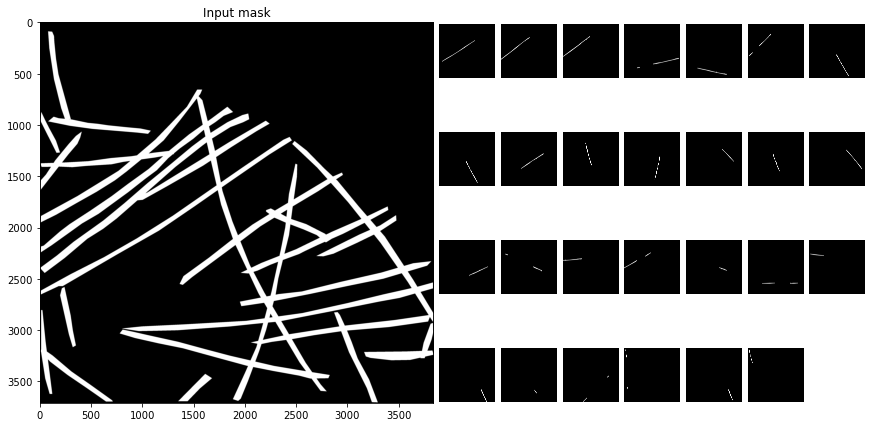

In [ ]:
# Plot grid view of instances
fig = grid_display_masks(name, mask, instances)

### Save plots for all images

In [ ]:
%matplotlib agg

for name, image, mask, (instances, line_ends) in zip(image_names,
                                                     images,
                                                     masks,
                                                     instance_masks,
                                                     ):

    fig1 = shade_instances(os.path.basename(name), image, instances, line_ends)
    fig2 = shade_instances(os.path.basename(name), mask, instances, line_ends)
    fig3 = grid_display_masks(name, mask, instances)
    
    if not os.path.exists('outputs/' + experiment + '/fig1'):
        os.makedirs('outputs/' + experiment + '/fig1')
        
    if not os.path.exists('outputs/' + experiment + '/fig2'):
        os.makedirs('outputs/' + experiment + '/fig2')                              
                              
    if not os.path.exists('outputs/' + experiment + '/fig3'):
        os.makedirs('outputs/' + experiment + '/fig3')
            
    fig1.savefig('outputs/' + experiment + '/fig1/' + os.path.basename(name))
    fig2.savefig('outputs/' + experiment + '/fig2/' + os.path.basename(name))
    fig3.savefig('outputs/' + experiment + '/fig3/' + os.path.basename(name))